# 1D Convolution NN



### Using the raw brachial waveforms and the derivatives --> 2 channels

This notebook contains the code for loading the brachial waveforms and the splitting it into 3 datasets:

    Train set 60%
    Validation set 20%
    Test set 20%

After the split it's done, a normalization step is applied to the datasets. Then, the model which is a 1D CNN is being trained and predictions of the value of the Ees(end systolic elastance) are being produced. The purpose of using a CNN is to predict the value of Ees in a non-invasive matter by directly using the timeseries data. In addition to the waveforms, as an input to the CNN a second channel is being added, which is the derivative of the waveforms.

The functions used for creating the CNN and training it can be found in the file NN_helpers.py (In the file there are constructions of architecture for 3 different CNNs, one of each for the inputs having 1channel, 2 and 3 channels).

In [ ]:
%matplotlib inline
import sys
sys.path.append('/content/drive/MyDrive/Project2_ML/Final_project')
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scripts.helpers import *
from scripts.NN_helpers import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Load Data

In [ ]:
DATA_PATH = "drive/MyDrive/Project2_ML/Final_project/Data/split_data/"

br_waveform = pd.read_csv(DATA_PATH+"BRACHIAL.csv", sep=',').set_index("id")

Splitting data to :

*   Train set 60%
*   Validation set 20%
*   Test set 20%




In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(br_waveform, ees, test_size = 0.20)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.20)

In [ ]:
X_train.shape

(2398, 200)

In [ ]:
X_train.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/X_train.csv') 

In [ ]:
X_validation.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/X_validation.csv') 

In [ ]:
X_test.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/X_test.csv') 

In [ ]:
y_train.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/y_train.csv') 

In [ ]:
y_validation.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/y_validation.csv') 

In [ ]:
y_test.to_csv('drive/MyDrive/Project2_ML/Final_project/Data/split_data/y_test.csv') 

### The derivatives of the waveforms

In [ ]:
derivatives_train = derivative(X_train,HR_train)
derivatives_validation = derivative(X_validation,HR_validation)
derivatives_test = derivative(X_test,HR_test)

In [ ]:
derivatives_train.shape,derivatives_validation.shape,derivatives_test.shape

((2398, 200), (600, 200), (750, 200))

In [ ]:
raw_waveforms_train = np.array(X_train)
waveforms_2_train = np.c_[raw_waveforms_train,derivatives_train] # adding the second channel
X_train = waveforms_2_train.reshape(X_train.shape[0],2,200)

In [ ]:
raw_waveforms_validation = np.array(X_validation)
waveforms_2_validation = np.c_[raw_waveforms_validation,derivatives_validation] # adding the second channel
X_validation = waveforms_2_validation.reshape(X_validation.shape[0],2,200)

In [ ]:
raw_waveforms_test = np.array(X_test)
waveforms_2_test = np.c_[raw_waveforms_test,derivatives_test] # adding the second channel
X_test = waveforms_2_test.reshape(X_test.shape[0],2,200)

In [ ]:
X_train.shape,X_validation.shape,X_test.shape

((2398, 2, 200), (600, 2, 200), (750, 2, 200))

### Normalization

In [ ]:
normalized_train = np.empty((X_train.shape))
normalized_valid = np.empty((X_validation.shape))

In [ ]:
normalized_test = np.empty((X_test.shape))

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[:,0,:])
normalized_train[:,0,:] = scaler.transform(X_train[:,0,:])
normalized_valid[:,0,:] = scaler.transform(X_validation[:,0,:])

In [ ]:
normalized_test[:,0,:] = scaler.transform(X_test[:,0,:])

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[:,1,:])
normalized_train[:,1,:] = scaler.transform(X_train[:,1,:])
normalized_valid[:,1,:] = scaler.transform(X_validation[:,1,:])

In [ ]:
normalized_test[:,1,:] = scaler.transform(X_test[:,1,:])

In [ ]:
normalized_train.shape, normalized_valid.shape, normalized_test.shape

((2398, 2, 200), (600, 2, 200), (750, 2, 200))

In [ ]:
X_train, X_validation, X_test = normalized_train, normalized_valid, normalized_test

In [ ]:
X_train.shape, X_validation.shape, X_test.shape

((2398, 2, 200), (600, 2, 200), (750, 2, 200))

In [ ]:
y_train.shape, y_validation.shape, y_test.shape

((2398, 1), (600, 1), (750, 1))

## Convolution model

In [ ]:
torch.cuda.is_available()

True

In [ ]:
NUM_EPOCHS = 300

##### TUNING HYPER PARAMETERS + Training

In [ ]:
learning_rate=[0.001,0.0001]
batch_size = [32,64,128,200,250]
parameters = [learning_rate,batch_size]

dataset_train = [np.array(X_train),np.array(y_train)]
dataset_test = [np.array(X_validation),np.array(y_validation)]

results=hypertuning_NN(dataset_train,dataset_test,parameters,NUM_EPOCHS,2)

Estimation

In [ ]:
torch.save(results[0][-1].state_dict(), "drive/MyDrive/Project2_ML/Final_project/Data/saved_model_2channels.pt")

In [ ]:
predictions = results[0][-1](torch.from_numpy(X_test).float().to(device))

In [ ]:
r2_score(y_test,predictions.view(-1).cpu().detach().numpy())

0.9380343043335836

In [ ]:
np.corrcoef(y_test.to_numpy().flatten(), predictions.view(-1).cpu().detach().numpy())[0,1]

0.9691020864186981

In [ ]:
mean_squared_error(y_test,predictions.view(-1).cpu().detach().numpy())

0.016172146270532074

In [ ]:
predictions = predictions.view(-1).cpu().detach().numpy()

In [ ]:
df = pd.DataFrame()
df["Predictions"] = predictions
df["Real"] = np.array(y_test).flatten()
df.to_csv("drive/MyDrive/Project2_ML/Final_project/NewData_results/ND_results_2Channel.csv")

In [ ]:
df_validation = pd.DataFrame()
df_validation["R2"]=results[0][0]
df_validation["loss"]=results[0][1]
df_validation["r"]=results[0][4]
df_validation.to_csv("drive/MyDrive/Project2_ML/Final_project/NewData_metrics_validation_set/ND_results_2Channel_normalized.csv")

In [ ]:
df_train = pd.DataFrame()
df_train["R2"]=results[0][2]
df_train["loss"]=results[0][3]
df_train.to_csv("drive/MyDrive/Project2_ML/Final_project/NewData_metrics_train_set/ND_results_2Channel_normalized.csv")

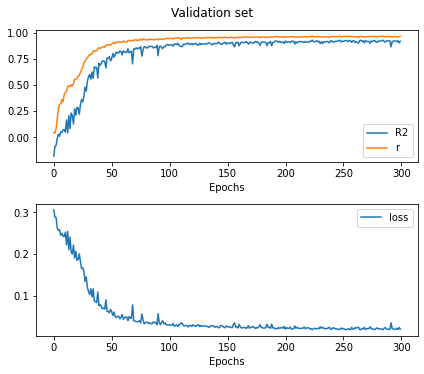

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5),sharey=False)
x = np.arange(0,NUM_EPOCHS)
ax1.plot(x,results[0][0],label="R2")
ax1.plot(x,results[0][4],label="r")
ax2.plot(x,results[0][1],label="loss")
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax1.legend()
ax2.legend()
f.tight_layout() 
f.suptitle("Validation set",y=1.03)
plt.show()

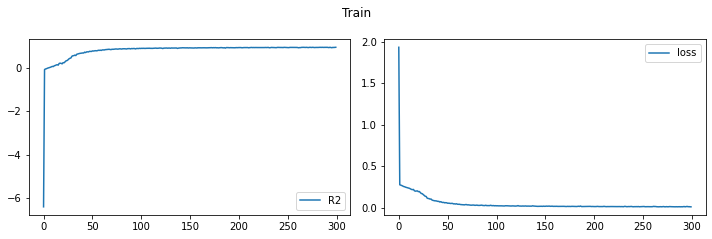

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3),sharey=False)
x = np.arange(0,NUM_EPOCHS)
ax1.plot(x,results[0][2],label="R2")
ax2.plot(x,results[0][3],label="loss")
ax1.legend()
ax2.legend()
f.tight_layout() 
f.suptitle("Train",y=1.09)
plt.show()